<a id="top"></a>
# Compute Items Bounding Box
First:
* [Load Parameters and Items](#load)

Then choose one operation:
* [Compute and Save](#compute)
* [Statistics](#statistics)
* [Plot Item Files](#plot)
* [Computing Test](#test)

## Load Parameters and Items<a id="load"></a>

In [1]:
import json
from utils import load_items

with open('parameters.json', 'r') as infile:
    params = json.load(infile)

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

items = load_items(ITEM_FOLDER)

## Compute and Save<a id="compute"></a>

In [9]:
import cv2, glob, json
from utils import imread_gray

def worker(item):
    folder = ITEM_FOLDER + '/' + item + '/'
    files = glob.glob(folder + '*_mask.pgm')
    for filename in files:
        mask = imread_gray(filename)
        if not mask is None:
            cnt, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            cnt = sorted(cnt, key=lambda x:cv2.contourArea(x), reverse=True)
            x,y,w,h = cv2.boundingRect(cnt[0])
            bbox = {'x':x,'y':y,'w':w,'h':h}
            with open(filename[:-9] + '_bbox.json', 'w') as outfile:
                json.dump(bbox, outfile)

In [10]:
%%time
from multiprocessing import Pool

print('Computing bounding boxes of images')
print('* resized to %d x %d' % (RESIZE_X,RESIZE_Y))
pool_size = 6
pool = Pool(pool_size)
result = []
for item in items:
    result.append( pool.apply_async(worker, (item,)) )
pool.close()
pool.join()
for r in result:
     r.get()

Computing bounding boxes of images
* resized to 600 x 600
CPU times: user 8.14 ms, sys: 20.7 ms, total: 28.8 ms
Wall time: 126 ms


## Statistics<a id="statistics"></a>

In [11]:
import glob, json

item_view = []
area = []
for item in items:
    folder = ITEM_FOLDER + '/' + item + '/'
    files = glob.glob(folder + '*_bbox.json')
    for filename in files:
        with open(filename, 'r') as infile:
            bbox = json.load(infile)
        x = bbox['x']
        y = bbox['y']
        w = bbox['w']
        h = bbox['h']
        item_view.append(filename)
        area.append(w*h)

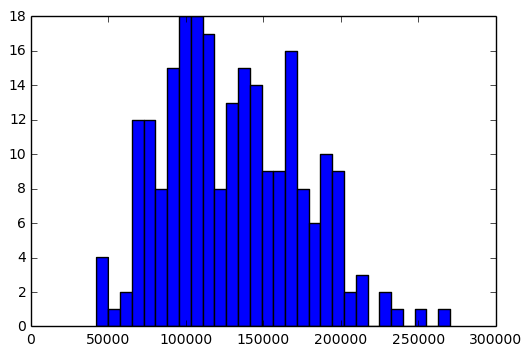

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(area,bins=30);

In [13]:
[(a, str(iv.split('/')[-1][:-10])) for a, iv in sorted(zip(area,item_view), reverse=True) if a>230000]

[(270399, 'toilet_brush_bottom-side_02'),
 (253227, 'plastic_wine _glass_top-side_01'),
 (233266, 'bath_sponge_bottom_01'),
 (232106, 'plastic_wine _glass_top-side_02')]

In [14]:
[(a, str(iv.split('/')[-1][:-10])) for a, iv in sorted(zip(area,item_view), reverse=True) if a<50000]

[(43806, 'fiskars_scissors_bottom-side_01'),
 (43608, 'reynolds_wrap_top_01'),
 (42739, 'reynolds_wrap_bottom_01'),
 (42381, 'fiskars_scissors_top-side_02')]

## Plot File<a id="plot"></a>

In [15]:
import cv2
from utils import imread_rgb
from matplotlib import pyplot as plt
%matplotlib inline

def load_and_plot(item,view):
    filename = ITEM_FOLDER + '/' + item + '/' + item + '_' + view + '.png'
    image_RGB = imread_rgb(filename)
    if not image_RGB is None:
        image_RGB = cv2.resize(image_RGB,(RESIZE_X,RESIZE_Y))
        with open(filename[:-4] + '_bbox.json', 'r') as infile:
            bbox = json.load(infile)
        x = bbox['x']
        y = bbox['y']
        w = bbox['w']
        h = bbox['h']
        image_plot = image_RGB.copy()
        cv2.rectangle(image_plot,(x,y),(x+w,y+h),(0,255,0),2)
        plt.subplot(121), plt.imshow(image_plot);
        plt.subplot(122), plt.imshow(image_RGB[y:y+h,x:x+w]), plt.axis('off');

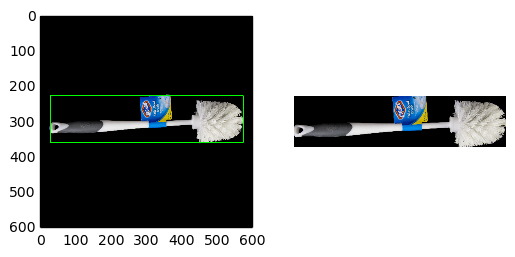

In [16]:
from ipywidgets import interact
views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
interact(load_and_plot,item=items,view=views);

### Plot All Items

In [ ]:
for item in items:
    for view in views:
        print(item + '_' + view)
        load_and_plot(item,view)
        plt.show()

## Computing Test<a id="test"></a>

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import cv2, numpy as np
from ipywidgets import interact
from utils import imread_rgb, imread_gray

def compute_and_plot(item,view):
    prefix = ITEM_FOLDER + '/' + item + '/' + item + '_' + view
    filename = prefix + '.png'
    image_RGB = imread_rgb(filename)
    if not image_RGB is None:
        image_RGB = cv2.resize(image_RGB,(RESIZE_X,RESIZE_Y))
        filename = prefix + '_mask.pgm'
        mask = imread_gray(filename)
        if not mask is None:
            cnt, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            cnt = sorted(cnt, key=lambda x:cv2.contourArea(x), reverse=True)
            x,y,w,h = cv2.boundingRect(cnt[0])
            image_plot = image_RGB.copy()
            cv2.rectangle(image_plot,(x,y),(x+w,y+h),(0,255,0),2)
            plt.subplot(121), plt.imshow(image_plot);
            plt.subplot(122), plt.imshow(image_RGB[y:y+h,x:x+w]), plt.axis('off');

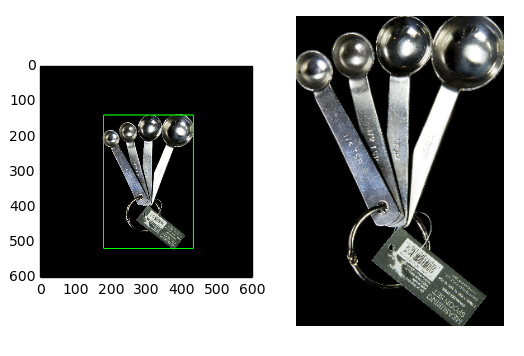

In [4]:
views = ['top_01','top-side_01','top-side_02','bottom_01','bottom-side_01','bottom-side_02']
interact(compute_and_plot,item=items,view=views);

### Compute and Plot All Items

In [ ]:
for item in items:
    for view in views:
        print(item + '_' + view)
        compute_and_plot(item,view)
        plt.show()

[Top](#top)